In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import time
import copy
import calc_vector
import multiprocessing as mp
import random

from scipy import sparse
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.sparse.linalg import spsolve

pd.set_option('display.max_columns', 100)

In [113]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

# Read Data

## Amazon Fashion

### Full CSJ fashion file

In [114]:
# df = pd.read_pickle('Data/df_amazon_csj_with_styles')
# df.head()

### CSJ 0.63m user above 5, r_u_i

In [115]:
df = pd.read_pickle('Data/df_amazon_csj_with_styles_0.63m_u_above_5_rui')
df.head()

,user,item,rating,verified
0,A2OLY7TMIYHOQQ,B00EAKJUUW,5.0,True
1,A3F6ZP5VM8QUC6,B00D98EGE6,5.0,True
2,A21PFJA2O7Z5GY,B01DTEXSHA,2.0,True
3,AV9HIUYXBZODJ,B0045DBUBQ,3.0,True
4,A73X3PFCRTJVX,B00DEWBMU8,5.0,True


## MovieLens

### 0.7m user above 5 r_u_i

In [116]:
# df = pd.read_pickle('Data/ml_0.7_u_above_5')
# print('rating interval:', df.rating.unique().min(), ',', df.rating.unique().max())
# df.head()

# Data Exploration

First filtering active users and rated items with x or more ratings:

In [117]:
user_ratings = df.groupby('user')['rating'].count()
item_ratings = df.groupby('item')['rating'].count()
norpu = user_ratings.mean()
norpi = item_ratings.mean()
total_users = df.user.unique().size
total_items = df.item.unique().size
sparseness = 1 - len(df) / (len(df['user'].unique()) * len(df['item'].unique()))

## Sub Sample

In [118]:
# df = df.sample(frac=0.9, random_state=1234)

rows  629889 
#ratings 629889 
#ratings/user 6.91 
#ratings/item 5.47 
average rating 4.30 
#users  91216 
#items  115063 
sparse  0.99994 %


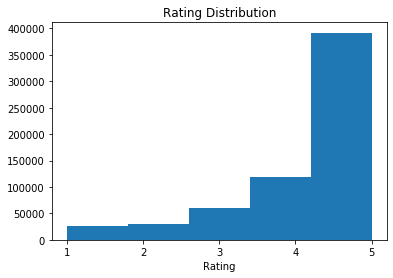

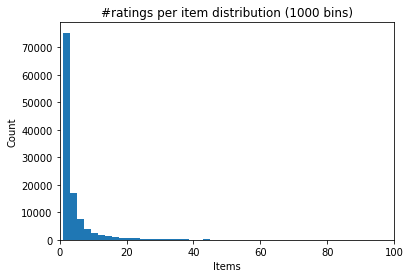

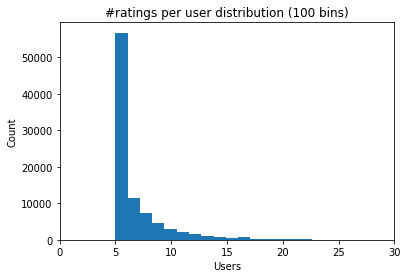

In [119]:
print('rows ', len(df), '\n#ratings', len(df[df['rating'] != 0]), '\n#ratings/user', round(norpu,2), '\n#ratings/item', round(norpi,2), '\naverage rating', "{0:.2f}".format(np.average(df['rating'])), '\n#users ', df['user'].unique().size, '\n#items ', df['item'].unique().size, '\nsparse ', round(sparseness,5), '%')
df.hist(column='rating', bins=5, grid=False)
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.xticks(range(1,6))
plt.savefig('Plots/Deliverables/rating_dist_ml')
plt.show()

plt.hist(item_ratings, bins = 1000)
plt.xlim([0,100])
plt.title('#ratings per item distribution (1000 bins)')
plt.xlabel('Items')
plt.ylabel('Count')
plt.savefig('Plots/Deliverables/#ratings_per_item_dist_ml')
plt.show()

plt.hist(user_ratings, bins = 100)
plt.xlim([0,30])
plt.title('#ratings per user distribution (100 bins)')
plt.xlabel('Users')
plt.ylabel('Count')
plt.savefig('Plots/Deliverables/#ratings_per_user_dist_ml')
plt.show()

## Verification Analysis
Only keep verified ratings

In [120]:
print('verified:', df['verified'].sum() / len(df))
df = df[df['verified']==True]
print('verified:', df['verified'].sum() / len(df))

verified: 0.9118257343754217
verified: 1.0


In [121]:
df['verified'] = 1

In [122]:
# r = df['rating']
# df['rating'] = df['verified']

In [123]:
df_og = df
df = df_og.sample(frac=0.2, random_state=1234)
total_users = df.user.unique().size
total_items = df.item.unique().size

In [124]:
df.head()

,user,item,rating,verified
24161,ABMRK1O13436Y,B00JBJCLG2,5.0,1
396411,A36IZ3GX3RI33W,B00VWKWWMG,5.0,1
426457,AZWGNYTKSK9JS,B000KPXYCG,5.0,1
587848,AQLT5XRHA958G,B000CEM6FG,5.0,1
198173,A31IV9AHRLVY3O,B0077BX3GI,5.0,1


# Data Prep
Create new ids for users and items that match the row and column indices of the user-item interaction matrix

In [125]:
def transform(df):
    items = df['item'].unique()
    itemsDF = pd.DataFrame(data=items, columns=['original_item_id'])
    itemsDF['new_item_id'] = itemsDF.index

    users = df['user'].unique()
    usersDF = pd.DataFrame(data=users, columns=['original_user_id'])
    usersDF['new_user_id'] = usersDF.index

    ratingDF = df.merge(itemsDF, left_on='item', right_on='original_item_id')
    ratingDF = ratingDF.drop(columns=['original_item_id'])

    ratingDF = ratingDF.merge(usersDF, left_on='user', right_on='original_user_id')
    ratingDF = ratingDF.drop(columns=['original_user_id'])

    df_new_ids = ratingDF
    print('Full data #row: ', df_new_ids.shape[0])
    
    return df_new_ids

df_new_ids = transform(df)

Full data #row:  114870


## Leave-one-out train test split

In [126]:
def leave_x_out(full_data, leave_out):
    # Input: data must be formatted by func: tranfsorm
    # Output: full_data = without all entries in leave one out set
    #         leave_one_out_set = data with one user and one item from full_data
    
    full_data['index'] = full_data.index
    user_items_ind = full_data.groupby('new_user_id')['index'].apply(list)
    index_to_drop = []
    
    for indices in user_items_ind:
        if len(indices) > leave_out:
            for to_leave_out in range(leave_out):
                index = indices[- to_leave_out]
                index_to_drop.append(index)
    
    leave_one_out_set = full_data.loc[index_to_drop]
    full_data_leave_one_out = full_data.drop(index_to_drop)
    
    return full_data_leave_one_out.drop(columns=['index']), leave_one_out_set.drop(columns=['index'])

In [127]:
def create_matrices(data, n_users, n_items):
        r = data['new_user_id']
        c = data['new_item_id']
        d = data['rating']
        m = sparse.csr_matrix((d, (r, c)), shape=(n_users, n_items))
        m_ones = m.copy()
        m_ones[m_ones > 0] = 1
                               
        return m, m_ones

In [128]:
train_set, test_set = leave_x_out(df_new_ids, 2)
val_set, test_set = leave_x_out(test_set, 1)

# Model

## Bayesian Personalized Ranking
- Paper: https://arxiv.org/pdf/1205.2618.pdf
- Code:  https://github.com/valerystrizh/bpr/blob/master/BPR.java

In [129]:
class BPR():
    def __init__(self, total_users, total_items, params):
        self.total_users = total_users
        self.total_items = total_items
        self.nolf = params['nolf']
        self.n_iterations = params['n_iterations']
        self.alpha = params['alpha']
        self.reg_user = params['reg_user']
        self.reg_item = params['reg_item']
        self.model = {}
        
    def fit(self, train_set, val_set):
        #Init
        p = np.random.normal(0, .1, (self.total_users, self.nolf))  # users
        q = np.random.normal(0, .1, (self.total_items, self.nolf))  # items
        train_ratings, train_ones = self.create_matrices(train_set)
        ui_tuples = [tuple(x) for x in train_set[['new_user_id', 'new_item_id', 'verified']].to_numpy()] #positive
        
        for iteration in range(self.n_iterations):
            total_loss = 0
            for u, i, r_ui in ui_tuples:
                i = int(i)
                j = int(random.sample(range(self.total_items), 1)[0]) # neg item
                j_v = int(train_ones[u,j]) # Value, NEEDED?
                
                while j == i or j_v > 0: # j cannot be the same item or an item with a 1
                    j = int(random.sample(range(self.total_items), 1)[0])
                    j_v = int(train_ones[u,j])

                pos_item_pred = self.predict(u,i,p,q)
                neg_item_pred = self.predict(u,j,p,q)
                diff = pos_item_pred - neg_item_pred

                loss_value = - np.log(self.sigmoid(diff)) #NEGATIVE?
                total_loss += loss_value

                diff_deriv = self.sigmoid(- diff)

                for f in range(self.nolf): # update each factor (see notes for derivatives)
                    p[u,f] += self.alpha * (diff_deriv * (q[i,f] - q[j,f]) - self.reg_user * p[u,f])
                    q[i,f] += self.alpha * (diff_deriv * p[u,f] - self.reg_item * q[i,f])
                    q[j,f] += self.alpha * (diff_deriv * (-p[u,f]) - self.reg_item * q[j,f])

                    total_loss += self.reg_user * p[u,f] * p[u,f] + self.reg_item * q[i,f] * q[i,f] + self.reg_item * q[j,f] * q[j,f]
            
            print(iteration, total_loss)
        
    def create_matrices(self, data):
        r = data['new_user_id']
        c = data['new_item_id']
        d = data['rating']
        m = sparse.csr_matrix((d, (r, c)), shape=(self.total_users, self.total_items))
        m_ones = m.copy()
        m_ones[m_ones > 0] = 1
                               
        return m, m_ones
    
    def sigmoid(self, x):
        return 1 / (1 + math.exp(-x))
    
    def predict(self, u, i, p, q):
        """Using MF now but can be any prediction algorithm"""
        return np.dot(p[u], q[i].T)
        

## Params

In [130]:
params = {
"nolf":20, #Size of latent feature vectors
"n_iterations":10,
"alpha":0.004, # Impact of confidence
          
#Regularizers, still tweaking the values
"reg_user":0.01,
"reg_item":0.01,
}

0 63942.291571812464
1 63911.21521617728
2 63879.20224864633
3 63838.820076028394
4 63806.07552446489
5 63766.48253650795
6 63747.841160796146
7 63692.03115208122
8 63655.20923135399
9 63622.22425708148


# Train Model

In [ ]:
model = BPR(total_users, total_items, params)
model.fit(train_set, val_set)